# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

При выполнении работы необходимо:
- Проанализировать и подготовить данные;
- Осуществить подбор оптимальных параметров для моделей;
- Обучить и протестировать несколько моделей;
- Сравнить модели по скорости и качеству.

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

## Подготовка данных

### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 354369 entries, 0 to 354368

Data columns (total 16 columns):

 #   Column             Non-Null Count   Dtype 

---  ------             --------------   ----- 

 0   DateCrawled        354369 non-null  object

 1   Price              354369 non-null  int64 

 2   VehicleType        316879 non-null  object

 3   RegistrationYear   354369 non-null  int64 

 4   Gearbox            334536 non-null  object

 5   Power              354369 non-null  int64 

 6   Model              334664 non-null  object

 7   Kilometer          354369 non-null  int64 

 8   RegistrationMonth  354369 non-null  int64 

 9   FuelType           321474 non-null  object

 10  Brand              354369 non-null  object

 11  Repaired           283215 non-null  object

 12  DateCreated        354369 non-null  object

 13  NumberOfPictures   354369 non-null  int64 

 14  PostalCode         354369 non-null  int64 

 15  LastSeen           354369 non-null  object

dtyp

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В данных имеется 15 столбцов с 354369 записей.

Я считаю, что столбцы:DateCrawled, PostalCode, LastSeen, DateCreated, NumberOfPictures неинформативны для модели предсказания. Нужно их удалить.

Столбцы VehicleType, Gearbox, Model, FuelType, Brand, Repaired являются категориальными и нужно заменить их значения на числовые.

In [4]:
#удаление столбцов
data = data.drop(['DateCrawled', 'PostalCode', 'LastSeen', 'DateCreated', 'NumberOfPictures'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 354369 entries, 0 to 354368

Data columns (total 11 columns):

 #   Column             Non-Null Count   Dtype 

---  ------             --------------   ----- 

 0   Price              354369 non-null  int64 

 1   VehicleType        316879 non-null  object

 2   RegistrationYear   354369 non-null  int64 

 3   Gearbox            334536 non-null  object

 4   Power              354369 non-null  int64 

 5   Model              334664 non-null  object

 6   Kilometer          354369 non-null  int64 

 7   RegistrationMonth  354369 non-null  int64 

 8   FuelType           321474 non-null  object

 9   Brand              354369 non-null  object

 10  Repaired           283215 non-null  object

dtypes: int64(5), object(6)

memory usage: 29.7+ MB


### Заполнение пропусков

In [5]:
data.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
dtype: int64

In [6]:
#заполнение пропусков
data['VehicleType'] = data['VehicleType'].fillna('Unknown')
data['Repaired'] = data['Repaired'].fillna('no')
data['Gearbox'] = data['Gearbox'].fillna(data['Gearbox'].value_counts().index[0])
data['FuelType'] = data['FuelType'].fillna(data['FuelType'].value_counts().index[0])
data['Model'] = data['Model'].fillna('Unknown')
data['Brand'] = data['Brand'].fillna('Unknown')

In [7]:
data.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

### Проверка аномальных значений

In [8]:
sorted(data['RegistrationYear'].unique())

[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

In [9]:
data.loc[(data['RegistrationYear'] < 1910) | (data['RegistrationYear'] > 2019)].count()[0]

171

In [10]:
data.loc[(data['RegistrationYear'] < 1910) | (data['RegistrationYear'] > 2019)] = data['RegistrationYear'].value_counts().index[0]


In [11]:
data['RegistrationMonth'].value_counts()

0       37220
3       34368
6       31501
4       29266
5       29149
7       27210
10      26098
12      24287
11      24184
9       23811
1       23214
8       22626
2       21264
2000      171
Name: RegistrationMonth, dtype: int64

In [12]:
data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = data['RegistrationMonth'].value_counts().index[1]

In [13]:
data['RegistrationMonth'].unique()

array([   3,    5,    8,    6,    7,   10,   12,   11,    2,    1,    4,
          9, 2000])

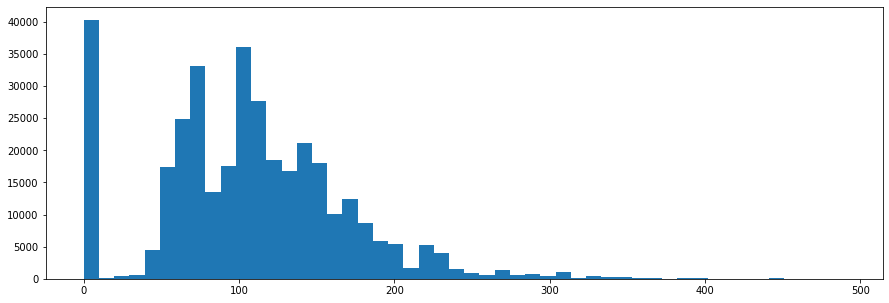

In [14]:
plt.figure(figsize=[15,5])
plt.hist(data.loc[data['Power']<500, 'Power'], bins=50);

In [15]:
data.loc[(data['Power']>500) | (data['Power']<10), 'Power'] = data['Power'].median()

### Разделение выборки

In [16]:
#раззделение на признаки и цели
data['Model'] = data['Model'].astype('str')
data['Brand'] = data['Brand'].astype('str')
features = data.drop('Price', axis=1)
target = data['Price']
#разделение на обучающую и тестовую выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

### Кодирование признаков

In [17]:
encoder = OrdinalEncoder()
features_train.loc[:,["Model","Brand"]] = encoder.fit_transform(features_train[["Model","Brand"]])
features_valid.loc[:,["Model","Brand"]] = encoder.transform(features_valid[["Model","Brand"]])
features_test.loc[:,["Model","Brand"]] = encoder.transform(features_test[["Model","Brand"]])
features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)
features_train.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,Brand,VehicleType_Unknown,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,...,Gearbox_manual,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_no,Repaired_yes
51358,2006,163.0,12.0,150000,1,3.0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
259924,2012,170.0,30.0,50000,11,2.0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
144289,2018,109.0,52.0,150000,11,6.0,1,0,0,0,...,1,0,0,0,0,0,0,1,1,0
346272,2003,170.0,156.0,150000,12,11.0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
247746,2000,75.0,175.0,150000,5,39.0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


**Вывод:** из изначальных данных были удалены неинформативные столбцы, заполнены пропуски, исправленны аномальные значения, осуществлено кодирование категориальных признаков. Данные разделены на признаки и целевой признак, а также на обучающую, валидационную и тестовую выборку.

## Обучение моделей

### LightGBM модель градиентного бустинга

In [18]:
%%time
best_booster = lgb.LGBMModel(objective="regression", learning_rate=0.2, seed=12345, max_depth=-1)
best_rmse = 2500

for learat in [0.1, 0.25, 0.5, 0.9]:
    for dept in [50, 100, 500]:
        for estim in [10, 20, 40]:

            booster = lgb.LGBMModel(objective="regression", learning_rate=learat, seed=12345, max_depth=dept, n_estimators=estim)
            booster.fit(features_train, target_train, eval_set=[(features_valid, target_valid),], eval_metric="rmse")
            test_preds = booster.predict(features_valid)
            
            if sqrt(mean_squared_error(target_valid, test_preds)) < best_rmse:
                best_booster = booster
                best_rmse = sqrt(mean_squared_error(target_valid, test_preds))
            
test_preds = best_booster.predict(features_valid)
print("\nTest  RMSE Score: %.2f"%sqrt(mean_squared_error(target_valid, test_preds)))

[1]	valid_0's rmse: 4194.9	valid_0's l2: 1.75972e+07

[2]	valid_0's rmse: 3924.95	valid_0's l2: 1.54052e+07

[3]	valid_0's rmse: 3689.32	valid_0's l2: 1.36111e+07

[4]	valid_0's rmse: 3484.59	valid_0's l2: 1.21423e+07

[5]	valid_0's rmse: 3306.54	valid_0's l2: 1.09332e+07

[6]	valid_0's rmse: 3152.86	valid_0's l2: 9.94051e+06

[7]	valid_0's rmse: 3018.83	valid_0's l2: 9.11336e+06

[8]	valid_0's rmse: 2902.24	valid_0's l2: 8.423e+06

[9]	valid_0's rmse: 2800.42	valid_0's l2: 7.84234e+06

[10]	valid_0's rmse: 2706.8	valid_0's l2: 7.32676e+06

[1]	valid_0's rmse: 4194.9	valid_0's l2: 1.75972e+07

[2]	valid_0's rmse: 3924.95	valid_0's l2: 1.54052e+07

[3]	valid_0's rmse: 3689.32	valid_0's l2: 1.36111e+07

[4]	valid_0's rmse: 3484.59	valid_0's l2: 1.21423e+07

[5]	valid_0's rmse: 3306.54	valid_0's l2: 1.09332e+07

[6]	valid_0's rmse: 3152.86	valid_0's l2: 9.94051e+06

[7]	valid_0's rmse: 3018.83	valid_0's l2: 9.11336e+06

[8]	valid_0's rmse: 2902.24	valid_0's l2: 8.423e+06

[9]	valid_0's rm

In [19]:
%%time
best_booster.fit(features_train, target_train, eval_set=[(features_valid, target_valid),], eval_metric="rmse")

[1]	valid_0's rmse: 3107.46	valid_0's l2: 9.65629e+06

[2]	valid_0's rmse: 2570.48	valid_0's l2: 6.60737e+06

[3]	valid_0's rmse: 2323.04	valid_0's l2: 5.39653e+06

[4]	valid_0's rmse: 2208.73	valid_0's l2: 4.87848e+06

[5]	valid_0's rmse: 2121.92	valid_0's l2: 4.50257e+06

[6]	valid_0's rmse: 2083	valid_0's l2: 4.33887e+06

[7]	valid_0's rmse: 2043.42	valid_0's l2: 4.17557e+06

[8]	valid_0's rmse: 2027.36	valid_0's l2: 4.11019e+06

[9]	valid_0's rmse: 2014.6	valid_0's l2: 4.05862e+06

[10]	valid_0's rmse: 1996.01	valid_0's l2: 3.98404e+06

[11]	valid_0's rmse: 1981.83	valid_0's l2: 3.92767e+06

[12]	valid_0's rmse: 1972.07	valid_0's l2: 3.88905e+06

[13]	valid_0's rmse: 1961.98	valid_0's l2: 3.84935e+06

[14]	valid_0's rmse: 1951.61	valid_0's l2: 3.80878e+06

[15]	valid_0's rmse: 1947.79	valid_0's l2: 3.7939e+06

[16]	valid_0's rmse: 1937.89	valid_0's l2: 3.75541e+06

[17]	valid_0's rmse: 1933.03	valid_0's l2: 3.73661e+06

[18]	valid_0's rmse: 1928.6	valid_0's l2: 3.71949e+06

[19]	va

LGBMModel(learning_rate=0.5, max_depth=50, n_estimators=40,
          objective='regression', seed=12345)

In [20]:
%%time
pred = best_booster.predict(features_valid)

CPU times: user 206 ms, sys: 0 ns, total: 206 ms

Wall time: 198 ms


In [21]:
sqrt(mean_squared_error(target_valid, pred))

1864.8667049697788

**Вывод** наибольшее влияние на время обучения данной модели оказывает глубина дерева, при ограничение глубины дерева построение градиентноого бустинга ускоряется. Осуществлен перебор нескольких параметров и найден лучший набор. Значение метрики rmse: 1863.26, время затраченное на обучение около 4 секунд.

### Случайный лес

In [22]:
min_rmse = 2500
for dept in range(5, 16, 5):
    for nest in range(10, 100, 20):
        model = RandomForestRegressor(n_estimators=nest, max_depth=dept, random_state=12345)
        model.fit(features_train, target_train)
        score = sqrt(mean_squared_error(target_valid, model.predict(features_valid)))
        if score < min_rmse:
            min_rmse = score
            best_model1 = model
            
print('RMSE =', min_rmse)

RMSE = 1816.0487426460995


In [23]:
%%time
best_model1.fit(features_train, target_train)

CPU times: user 55.3 s, sys: 316 ms, total: 55.6 s

Wall time: 55.7 s


RandomForestRegressor(max_depth=15, n_estimators=90, random_state=12345)

In [24]:
%%time
pred = best_model1.predict(features_valid)

CPU times: user 1.18 s, sys: 7.56 ms, total: 1.19 s

Wall time: 1.19 s


In [25]:
sqrt(mean_squared_error(target_valid, pred))

1816.0487426460995

**Вывод:** для модели случайного леса лучшее значение метрики rmse: 1816.22, время затраченное на обучение 71 секунда, предсказание 1,5 секунд.

### Линейная регрессия

In [26]:
model = LinearRegression()

In [27]:
%%time
model.fit(features_train, target_train)

CPU times: user 350 ms, sys: 246 ms, total: 596 ms

Wall time: 584 ms


LinearRegression()

In [28]:
%%time
pred = model.predict(features_valid)

CPU times: user 36.3 ms, sys: 59.4 ms, total: 95.8 ms

Wall time: 97.8 ms


In [29]:
sqrt(mean_squared_error(target_valid, pred))

2982.2014687909136

**Вывод:** для модели линейно регрессии значение метрики rmse: 3538.62. Время на обучение и предсказание меньше секунды.

## Анализ моделей

In [30]:
print(target_train.shape, target_valid.shape)

(212621,) (70874,)


**Вывод:** при размере обучающей выборки 265776 строк и 24 признака и тестовой 88593 строк получены следующие результаты:
- Модель градиентного бустинга:
    - rmse: 1863.26;
    - Время обучения: 4,3 секунды;
    - Время предсказания: 0,2 секунды.
- Случайный лес:
    - rmse: 1816.22;
    - Время обучения: 71 секунда;
    - Время предсказания: 1,5 секунды.
- Линейная регрессия:
    - rmse: 3538.62;
    - Время обучения: 0,45 секунды;
    - Время предсказания: 0,007 секунды.
    
Таким образом, модель линейной регресии работает быстрее других, но ее точность недостаточна. Модель градиентного бустинга показала хороший результат метрики rmse и выполняется быстрее случайного леса, из трех рассмотренныз методов, использование градиентного бустинга является наиболее оптимальным.

финальное тестирование лучшей модели на тестовой выборке

In [31]:
%%time
sqrt(mean_squared_error(target_test, best_booster.predict(features_test)))

CPU times: user 200 ms, sys: 7.81 ms, total: 208 ms

Wall time: 200 ms


1884.3456081752067

Предсказание модель выполнила быстро, значение метрики rmse изменилось незначительно, по сравнению с результатами полученными при обучении.